In [2]:
from pathlib import Path
import pandas as pd 
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path('datasets/housing.tgz')
    if not tarball_path.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url=url, filename=tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path='datasets')
    return pd.read_csv(Path('datasets/housing/housing.csv'))

housing = load_housing_data()

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

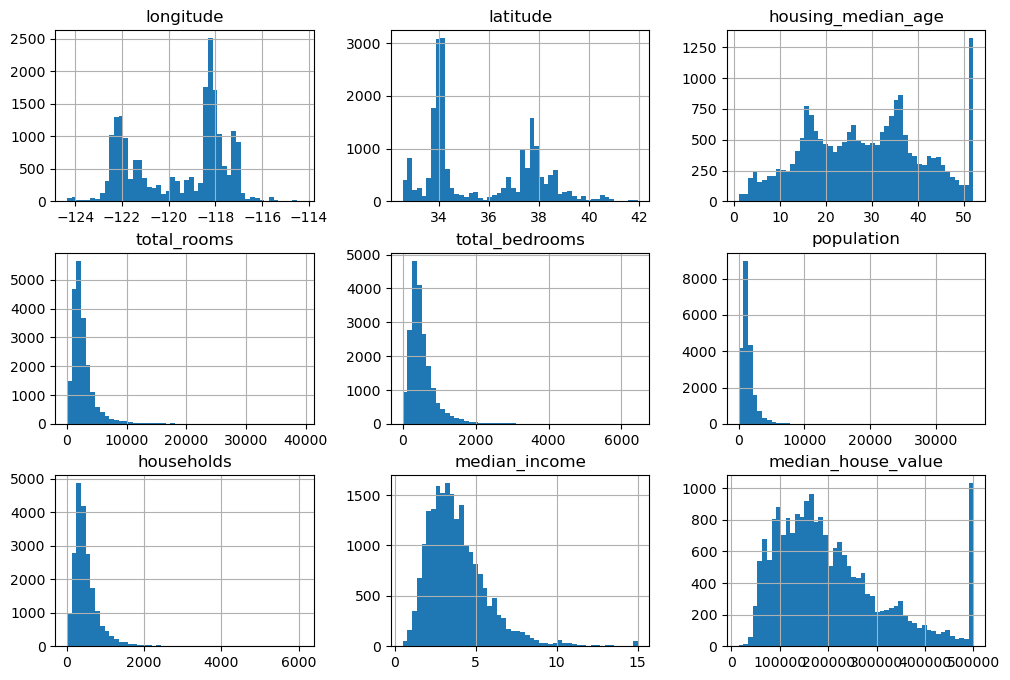

In [6]:
housing.hist(bins=50, figsize=(12, 8));

In [7]:
import numpy as np

housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

Text(0, 0.5, 'Number of categories')

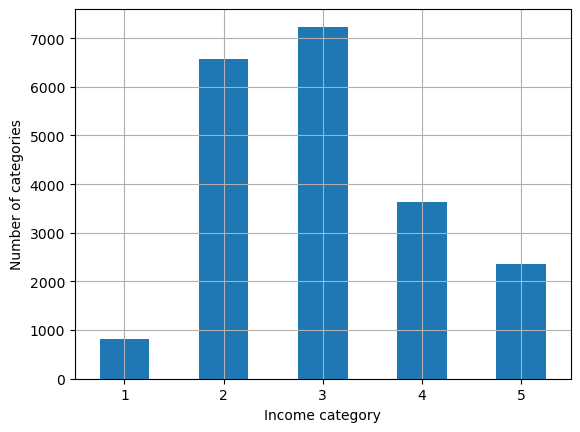

In [8]:
import matplotlib.pyplot as plt

housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income category')
plt.ylabel('Number of categories')

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'])

In [10]:
train_set['income_cat'].value_counts() / len(train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [11]:
for set_ in (train_set, test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [12]:
housing = train_set.copy()

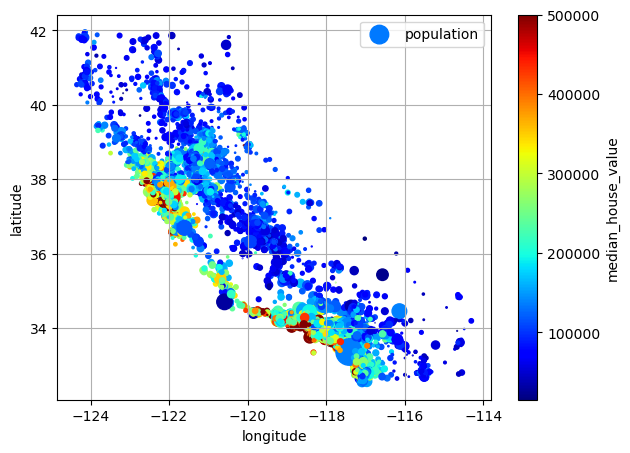

In [13]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True, s=housing['population'] / 100, label='population',
             c='median_house_value', cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(7, 5));

In [14]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689188
total_rooms           0.142767
housing_median_age    0.104587
households            0.070836
total_bedrooms        0.055550
population           -0.022138
longitude            -0.048141
latitude             -0.142512
Name: median_house_value, dtype: float64

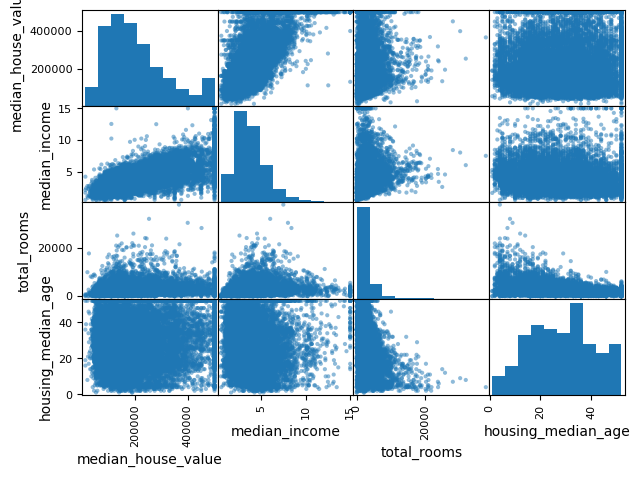

In [15]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(7, 5));

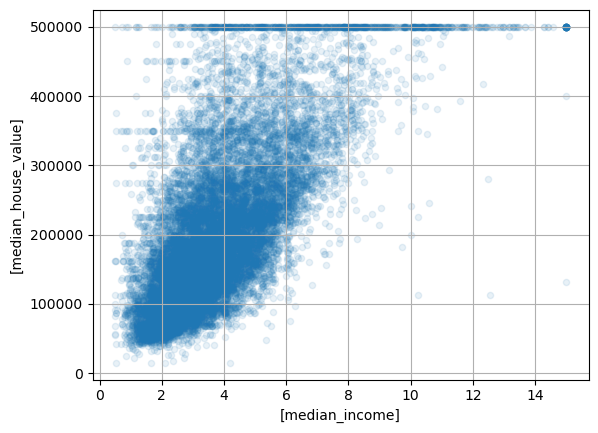

In [16]:
housing.plot(kind='scatter', x=['median_income'], y=['median_house_value'], alpha=0.1, grid=True);

In [17]:
housing['rooms_per_house'] = housing.total_rooms / housing.households
housing['bedrooms_ratio'] = housing.total_bedrooms / housing.total_rooms
housing['people_per_house'] = housing.population / housing.households

In [18]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.689188
rooms_per_house       0.171900
total_rooms           0.142767
housing_median_age    0.104587
households            0.070836
total_bedrooms        0.055550
population           -0.022138
people_per_house     -0.033240
longitude            -0.048141
latitude             -0.142512
bedrooms_ratio       -0.257577
Name: median_house_value, dtype: float64

In [19]:
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

In [20]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [21]:
housing_num = housing.select_dtypes(include=[np.number])

In [22]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [23]:
imputer.statistics_

array([-118.5    ,   34.26   ,   29.     , 2127.     ,  435.     ,
       1167.     ,  409.5    ,    3.54155])

In [24]:
housing_num.median().values

array([-118.5    ,   34.26   ,   29.     , 2127.     ,  435.     ,
       1167.     ,  409.5    ,    3.54155])

In [25]:
X = imputer.transform(housing_num)

In [26]:
housing_trn = pd.DataFrame(X, index=housing_num.index, columns=housing_num.columns)

In [27]:
housing_cat = housing.select_dtypes(exclude=np.number)

In [28]:
housing_cat.head()

,ocean_proximity
2789,INLAND
10415,INLAND
9864,<1H OCEAN
5942,<1H OCEAN
16423,NEAR BAY


In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [30]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [31]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [32]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[['housing_median_age']], [[35]], gamma=0.1)

In [33]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
housing_num_standard_scaled = standard_scaler.fit_transform(housing_num)

In [34]:
from sklearn.linear_model import LinearRegression

target_scalar = StandardScaler()
scaled_labels = target_scalar.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)
some_new_data = housing[['median_income']].iloc[:5] # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scalar.inverse_transform(scaled_predictions)

In [35]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[['median_income']], housing_labels)
predictions = model.predict(some_new_data)

### Custom Transformer

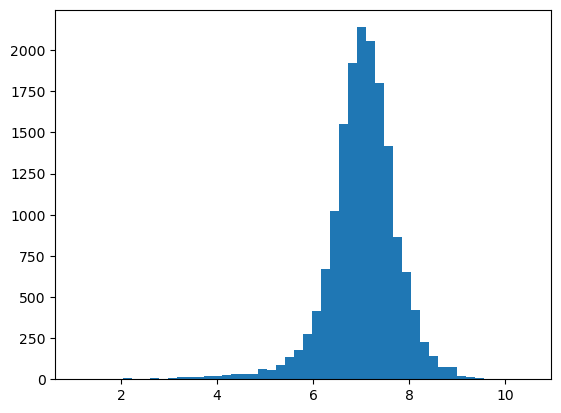

In [36]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing['population'])
plt.hist(x=log_pop, bins=50);

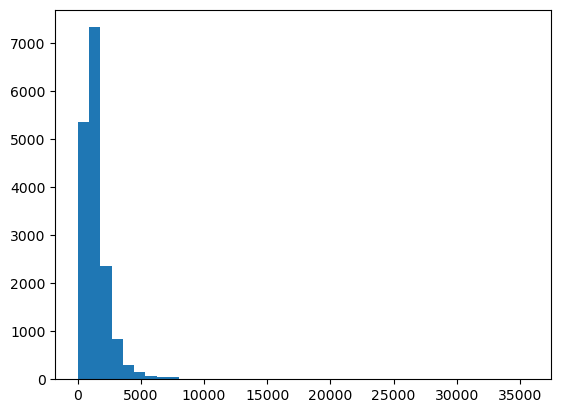

In [37]:
plt.hist(housing['population'], bins=40);

In [38]:
rbf_transformer = FunctionTransformer(rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[['housing_median_age']])

In [39]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[['latitude', 'longitude']])

In [40]:
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalarClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True): # no *args and **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):   # y is required even though we don't use it
        X = check_array(X)      # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]    # every estimator stores this in fit()
        return self # always return self!
    
    def transform(self, X):
        check_is_fitted(self)   # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X -= self.mean_
        return X / self.scale_

In [42]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0):
        self.n_clusters = n_clusters
        self.gamma = gamma
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return (f'Cluster {i} similarity' for i in range(self.n_clusters))

In [43]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.)
similarities = cluster_simil.fit_transform(housing[['latitude', 'longitude']], sample_weight=housing_labels)

In [44]:
similarities[:3].round(2)

array([[0.11, 0.  , 0.93, 0.  , 0.  , 0.  , 0.01, 0.22, 0.  , 0.  ],
       [0.01, 0.  , 0.01, 0.98, 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.94, 0.  , 0.  , 0.19, 0.12, 0.  , 0.  , 0.  , 0.85]])

### Transformation Pipeline

In [45]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('standardize', StandardScaler())
])

In [46]:
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

In [47]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-0.89,  1.4 ,  0.43, -0.08, -0.08, -0.31, -0.11, -0.43],
       [-0.09,  0.55, -0.29,  0.04, -0.08, -0.15, -0.09, -0.81]])

In [48]:
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
cat_attribs = ['ocean_proximity']

cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs)
])

In [50]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=np.object_))
)

In [51]:
housing_prepared = preprocessing.fit_transform(housing)

In [52]:
class RatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return (X[:, [0]] / X[:, [1]])
    
    def get_feature_names_out(self, input_features=None):
        return ['ratio']
    
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.log(X)

    def inverse_transform(self, X):
        return np.exp(X)

    def get_feature_names_out(self, input_features=None):
        return [f"log_{f}" for f in input_features]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        RatioTransformer(),
        StandardScaler()
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    LogTransformer(),
    StandardScaler()
)
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.)
default_num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

preprocessing = ColumnTransformer([
    ('bedrooms', ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', ratio_pipeline(), ['total_rooms', 'households']),
    ('people_per_house', ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline)

In [53]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [54]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__log_total_bedrooms',
       'log__log_total_rooms', 'log__log_population',
       'log__log_households', 'log__log_median_income',
       'geo__Cluster 0 similarity', 'geo__Cluster 1 similarity',
       'geo__Cluster 2 similarity', 'geo__Cluster 3 similarity',
       'geo__Cluster 4 similarity', 'geo__Cluster 5 similarity',
       'geo__Cluster 6 similarity', 'geo__Cluster 7 similarity',
       'geo__Cluster 8 similarity', 'geo__Cluster 9 similarity',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'remainder__housing_median_age'],
      dtype=object)

### Select and Train a Model

In [55]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiotransformer',
                                                                   RatioTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_b...
                                                   'households',
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x73edc67909b0>)])),
                ('linearregression', LinearRegression())])

In [56]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)   # -2 = rounded to the nearest hundred

array([140800.,  83600., 201600., 248800., 197600.])

In [57]:
housing_labels.iloc[:5].values

array([133000.,  90600., 196500., 224200., 316700.])

In [58]:
from sklearn.metrics import root_mean_squared_error
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68956.24056982377

In [59]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiotransformer',
                                                                   RatioTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_b...
                                                   'households',
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x73edc67909b0>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [60]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

In [61]:
from sklearn.model_selection import cross_val_score

tree_rmse = -cross_val_score(tree_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=10)

In [62]:
pd.Series(tree_rmse).describe()

count       10.000000
mean     67566.878724
std       3946.314442
min      60975.381941
25%      65345.165115
50%      66500.156374
75%      69912.271440
max      74789.128025
dtype: float64

In [63]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor())
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels, scoring='neg_root_mean_squared_error', cv=5)

In [64]:
pd.Series(forest_rmse).describe()

count        5.000000
mean     47686.426032
std        724.613552
min      47037.984156
25%      47226.757656
50%      47382.335795
75%      47957.289944
max      48827.762609
dtype: float64

### Fine-Tune your Model

In [65]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('random_forest', RandomForestRegressor())
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]}
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=2, scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)


/home/nemo/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratiotransformer',
                                                                                          RatioTransformer()),
                                                                                         ('standardscaler',
                                                                                          Stand...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x73edc67909b0>)])),
                                       ('random_forest',
                                        RandomForestRegressor())]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [66]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [67]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res.drop(labels=['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params',
                     'std_test_score', 'rank_test_score'], axis=1, inplace=True)
cv_res.rename({'param_preprocessing__geo__n_clusters': 'n_clusters', 'param_random_forest__max_features': 'max_features',
               'split0_test_score': 'split0', 'split1_test_score': 'split1'}, axis=1, inplace=True)
cv_res['mean_test_rmse'] = -cv_res['mean_test_score']
cv_res.head()

,n_clusters,max_features,split0,split1,mean_test_score,mean_test_rmse
12,15,6,-45486.256713,-45585.381927,-45535.819320,45535.819320
13,15,8,-45607.613535,-45604.550106,-45606.081820,45606.081820
14,15,10,-46017.232885,-46252.133064,-46134.682974,46134.682974
9,10,6,-46523.304002,-46426.515213,-46474.909607,46474.909607
7,10,6,-46497.447566,-46493.397925,-46495.422745,46495.422745


### Randomized Search

In [68]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, scoring='neg_root_mean_squared_error', n_iter=10, cv=2, verbose=4
)

rnd_search.fit(housing, housing_labels)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END preprocessing__geo__n_clusters=41, random_forest__max_features=4;, score=-43691.947 total time=   2.4s
[CV 2/2] END preprocessing__geo__n_clusters=41, random_forest__max_features=4;, score=-44521.825 total time=   2.4s
[CV 1/2] END preprocessing__geo__n_clusters=12, random_forest__max_features=13;, score=-47151.396 total time=   6.3s
[CV 2/2] END preprocessing__geo__n_clusters=12, random_forest__max_features=13;, score=-47338.437 total time=   6.3s
[CV 1/2] END preprocessing__geo__n_clusters=8, random_forest__max_features=19;, score=-48990.589 total time=   9.0s
[CV 2/2] END preprocessing__geo__n_clusters=8, random_forest__max_features=19;, score=-49261.115 total time=   8.9s
[CV 1/2] END preprocessing__geo__n_clusters=12, random_forest__max_features=8;, score=-46052.870 total time=   4.1s
[CV 2/2] END preprocessing__geo__n_clusters=12, random_forest__max_features=8;, score=-46477.803 total time=   4.1s
[CV 1/2] 

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ratiotransformer',
                                                                                                RatioTransformer()),
                                                                                               ('standardscaler'...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x73edc67909b0>)])),
                                             ('random_forest',
                                              RandomForestRegressor())]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73edbf3f5e80>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73edd0ec6360>},
                   scoring='neg_root_mean_squared_error', verbose=4)

In [69]:
final_model = rnd_search.best_estimator_    # includes preprocessing
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.06, 0.06, 0.05, 0.01, 0.01, 0.01, 0.01, 0.18, 0.02, 0.01, 0.01,
       0.02, 0.01, 0.01, 0.  , 0.01, 0.02, 0.03, 0.03, 0.02, 0.02, 0.01,
       0.03, 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.02, 0.01, 0.01, 0.01, 0.02, 0.04, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.06, 0.  , 0.  , 0.  , 0.01])

In [70]:
sorted(zip(feature_importances,
           final_model['preprocessing'].get_feature_names_out()),
           reverse=True)

[(0.1783579974349945, 'log__log_median_income'),
 (0.060592971750878195, 'rooms_per_house__ratio'),
 (0.059133686258367034, 'cat__ocean_proximity_INLAND'),
 (0.05845575998925335, 'bedrooms__ratio'),
 (0.04762969850573384, 'people_per_house__ratio'),
 (0.04001530165412327, 'geo__Cluster 30 similarity'),
 (0.03403479057476286, 'geo__Cluster 10 similarity'),
 (0.027326970942293617, 'geo__Cluster 9 similarity'),
 (0.025087961412093778, 'geo__Cluster 14 similarity'),
 (0.024327123752022603, 'geo__Cluster 3 similarity'),
 (0.020771990913081496, 'geo__Cluster 17 similarity'),
 (0.01931688104505803, 'geo__Cluster 0 similarity'),
 (0.01894334078491993, 'geo__Cluster 23 similarity'),
 (0.01729337140583641, 'geo__Cluster 25 similarity'),
 (0.017028066286298313, 'geo__Cluster 8 similarity'),
 (0.01636021299444243, 'geo__Cluster 29 similarity'),
 (0.015829498978397423, 'geo__Cluster 12 similarity'),
 (0.015192936848457628, 'geo__Cluster 11 similarity'),
 (0.014814637968033522, 'geo__Cluster 24 simi

### Evaluate Your System on the Test Set

In [71]:
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value']

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41486.70041208454


In [72]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([39379.95533933, 43491.51342086])

### Exercises

1. Try a support vector machine regressor (sklearn.nvm.SVR) with various hyperparameters, such as kernel='linear' (with various values for the C hyperparameter) or kernel='rbf' (with various values for the C and gamma hyperparameters). Note that support vector machines don't scale well to large datasets, so you should probably train your model on just the first 5000 instances of the training set and use only 3-fold cross-validation, or else it will take hours. Don't worry about what the hyperparameters mean for now; we'll duscuss them in Chapter 5. How does the best SVR predictor perform?

In [73]:
housing_trn, housing_trn_labels = housing[:5000], housing_labels[:5000]

In [84]:
from sklearn import svm

svr = Pipeline([
    ('preprocessing', preprocessing),
    ('svm', svm.SVR()),
])

In [85]:
svr.fit(housing_trn, housing_trn_labels)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ratiotransformer',
                                                                   RatioTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedro...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo', ClusterSimilarity(),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x73edc67909b0>)])),
                ('svm', SVR())])

In [87]:
housing_trn_preds = svr.predict(housing_trn)
svr_rmse = root_mean_squared_error(housing_trn_labels, housing_trn_preds)
svr_rmse

118079.89633148497

In [95]:
full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('svr', svm.SVR()),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'svr__kernel': ['linear'],
     'svr__C': [20, 24]},
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'svr__kernel': ['rbf'],
     'svr__C': [10, 20],
     'svr__gamma': ['scale', 'auto', 0.1, 0.4]}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)
grid_search.fit(housing_trn, housing_trn_labels)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/nemo/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ratiotransformer',
                                                                                          RatioTransformer()),
                                                                                         ('standardscaler',
                                                                                          Stand...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x73edc67909b0>)])),
                                       ('svr', SVR())]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'svr__C': [20, 24], 'svr__kernel': ['linear']},
                         {'preprocessing__geo__n_clusters': [5, 8, 10],
                          'svr__C': [10, 20],
                          'svr__gamma': ['scale', 'auto', 0.1, 0.4],
                          'svr__kernel': ['rbf']}],
             scoring='neg_root_mean_squared_error', verbose=1)

In [93]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 10, 'svr__C': 24, 'svr__kernel': 'linear'}

2. Try replacing the GridSearchCV with a RandomizedSearchCV.

In [99]:
param_distribs = [
    {'preprocessing__geo__n_clusters': randint(low=10, high=40),
     'svr__kernel': ['linear'],
     'svr__C': randint(low=20, high=80)},
    {'preprocessing__geo__n_clusters': randint(low=10, high=40),
     'svr__kernel': ['rbf'],
     'svr__C': randint(low=20, high=80),
     'svr__gamma': ['scale', 'auto']}
]
rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=40, cv=3, scoring='neg_root_mean_squared_error', random_state=42,
    verbose=1
)
rnd_search.fit(housing_trn, housing_trn_labels)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('ratiotransformer',
                                                                                                RatioTransformer()),
                                                                                               ('standardscaler'...
                                         'svr__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73ed9f6db770>,
                                         'svr__kernel': ['linear']},
                                        {'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73ed9f7bbe00>,
                                         'svr__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73ed9f7b86e0>,
                                         'svr__gamma': ['scale', 'auto'],
                                         'svr__kernel': ['rbf']}],
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [108]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_svr__C,param_svr__kernel,param_svr__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
35,0.386514,0.015596,0.143559,0.009200,37,79,linear,NaN,"{'preprocessing__geo__n_clusters': 37, 'svr__C...",-82656.375140,-81636.646116,-76628.082589,-80307.034615,2634.511698,1
31,0.386045,0.015361,0.141876,0.008059,37,76,linear,NaN,"{'preprocessing__geo__n_clusters': 37, 'svr__C...",-83008.707124,-81844.581313,-76891.929064,-80581.739167,2652.020761,2
14,0.374664,0.017390,0.137224,0.008969,29,76,linear,NaN,"{'preprocessing__geo__n_clusters': 29, 'svr__C...",-83178.157405,-82008.897434,-77538.834892,-80908.629910,2430.148290,3
4,0.386757,0.012954,0.145364,0.007388,33,72,linear,NaN,"{'preprocessing__geo__n_clusters': 33, 'svr__C...",-83526.690639,-82259.152874,-77486.121441,-81090.654984,2600.789566,4
33,0.365710,0.018512,0.135142,0.008540,27,66,linear,NaN,"{'preprocessing__geo__n_clusters': 27, 'svr__C...",-84158.822656,-83259.713745,-78336.109685,-81918.215362,2559.389253,5
